In [2]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 


def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for line in lines: 
        if line not in unique_lines:
            unique_lines.append(line)
    return("\n").join(unique_lines)

In [3]:
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
# If you're setting the API key directly in your script, uncomment the next line 

def room_setup(scene_descriptor, api_key=api_key):
    url = 'https://api.openai.com/v1/chat/completions'
    headers = {
        'Authorization': f'Bearer {api_key}', 
        'Content-Type': 'application/json',
            }
    
    # Read the contents of the .py file
    file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
    with open(file_path, 'r') as file:
        file_contents = file.read()

    prompt1 = "I am designing the layout for" + scene_descriptor + ". Please give me the dimensions of the room,"
    prompt1 += """ as well as the number of windows, doors, and sockets. For each window, door, and socket tell me the dimensions (in meters),
    which wall it should be on, as well as where on the wall it should be (this is a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up:
    {Room: width = 5,  length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}, etc.
    The windows and doors should all have length 0.1. Ensure that every object has dimensions, position, and wall.
     No other text please. Just the list with no commentary or explanation."""
    response1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt1}],
        max_tokens=500
    )
    objects = response1.choices[0].message.content.split("}, {")
    prompt2 = "I am going to give you a set of functions that are used to create a room and put objects in it. The functions are as follows:"
    prompt2 += file_contents
    prompt2 += f"I now want, for each element in this list: {objects}, with room descriptor:" + scene_descriptor + ", for you to translate it into a function call using the functions I gave you above."
    prompt2 += " For example, given the room descriptor 'a small kitchen' as well as the list: "
    prompt2 += "{Room: width = 5,  length = 6}, {Object type: window, Number: 1,  width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:"
    prompt2 += "kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3)."
    prompt2 += " Return only the python script. No other text. Please ensure the correct number of inputs are given for each function."

    # Define the request payload
    data = {
        "model": "gpt-4",
        "messages": [
            {"role": "user", "content": prompt2}
        ]
    }
    
    # Make the API call
    response2 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response2.status_code == 200:
        response_data2 = response2.json()
        if "```python" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        elif "```" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        else: 
            response2 = response_data2['choices'][0]['message']['content']
    else:
        print('Failed to get a response')
        print(response2.text)

    return response1, response2

scene_descriptor = "a bedroom for twins" #"a minimalist living room" #"a bedroom for a student in a university dorm with a single bed"
response1, response2 = room_setup(scene_descriptor)

## Check that the room was created, if not, rerun the room setup function
if 'create_room' not in response2: 
    print("response2 did not setup the room correctly, rerunning the room setup.")
    response1, response2 = room_setup(scene_descriptor)

## Account for any additional function calls (of other functions) by only taking the lines in the code that are relevant to the task   
lines = response2.split("\n")
response2 = [i for i in lines if 'create_room' in i]
for line in lines[1:]: 
    if "create_fixed_object" in line: 
        response2.append(line)

response2 = ("\n").join(response2)
width = (response2.split("create_room("))[1].split(",")[0]
length = (response2.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = (response2.split("create_room("))[0].split("=")[0].strip()

In [4]:
lang_prompt1 = "I am designing the layout of a" +  scene_descriptor + "that is" + width + "m x " + length + "m."
lang_prompt1 += """Interior designers suggest that a good layout will have different regions in the room for different functions.
What regions should I use, and how many regions should there be based on the description (minimum is 1 region and maximum is 5) """ + scene_descriptor + """, as well 
as the size of the room (if the room is small, don't give too many regions). Return this as a simple bullet list of regions to include, if there are choices to be made e.g. which of the regions
or how many regions, please make those choices. Only return the list of regions and the number of regions. No other information please."""

lang1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt1}],
        max_tokens=500
    )

print(lang1.choices[0].message.content)

lang_prompt2 = """The room is described as """ + scene_descriptor + """. Now for each one of the regions returned in this:""" + lang1.choices[0].message.content + """, what
is the most important object to include (per region), and what are its dimensions (give width of back of object and length of side of object not height) 
all in meters. ONLY one object per region (there can be two of the same object if NECESSARY). The size of the room is"""  + width + "m x " + length + """m, bear this in mind when choosing the objects and the 
size of the objects. Give no other information please. The primary objects should not cover more than 25 percent of the room area."""


lang2 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt2}],
        max_tokens=2000
    )

print(lang2.choices[0].message.content)

lang_prompt3 = """For each of these objects""" + lang2.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc... 
(return these as a bullet list for each object). Include practical things like whether it should be against a wall 
and what side (one of: left, right, top/back, bottom/front) of it should be against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), or which side should be accessible for use etc. 
Only give these constraints and considerations, no other information. """
lang3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3.choices[0].message.content)

lang_prompt4 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang3.choices[0].message.content + """ that depend only on each other.
For example, maybe a desk should not be close to a bed, etc. Only give the constraints and considerations between objects, no other information.."""

lang4 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4.choices[0].message.content)

- Sleeping Area
- Study/Work Area
- Closet/Storage Area
- Sleeping Area: Twin Beds (2 beds)
  - Dimensions each: 1.0m x 2.0m

- Study/Work Area: Desk (2 desks)
  - Dimensions each: 1.2m x 0.6m

- Closet/Storage Area: Wardrobe
  - Dimensions: 2.0m x 0.6m
### Sleeping Area: Twin Beds (2 beds)
- Each bed should be placed with one of the longer sides (2.0m) against a wall to save space.
- Ensure both beds have easy access from one of the shorter sides (1.0m).
- Avoid placing the beds directly under windows to prevent drafts and noise distraction.
- Consider electrical outlets; avoid blocking them or ensure they are accessible for bedside lamps or chargers.
- Maintain a clear pathway for safe movement around the beds.
- Beds should not obstruct doors or closets.

### Study/Work Area: Desk (2 desks)
- Each desk should have the longer side (1.2m) against a wall for stability.
- Place desks near electrical outlets for computers, lamps, or other electronic devices.
- Avoid placing desks directl

In [5]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
        }

# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()

prompt3 = "Given the room name: " + room_name + ", and the regions: " + lang1.choices[0].message.content
prompt3 += " Using the functions in the script, initialise each region. For example 'eating region' might output 'eating_region = region_setup(kitchen, 'eating', 0)."
prompt3 += " No other text please, only the python script. Don't include the room so far in the output."
prompt3 += file_contents
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt3}
            ]
    }
    
# Make the API call
response3 = requests.post(url, headers=headers, json=data)  
# Check the response
if response3.status_code == 200:
    response_data3 = response3.json()
    if "```python" in response_data3['choices'][0]['message']['content']:
        ## Remove any function calls that aren't region setups
        response3 = response_data3['choices'][0]['message']['content'].split("```python")[1].split("```")[0]
        lines = response3.split("\n")
        response3 = []
        for line in lines: 
            if "region_setup" in line: 
                response3.append(line)
        response3 = ("\n").join(response3)
        response3 = response2 + "\n" + (response_data3['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        ## Remove any function calls that aren't region setups
        lines = response_data3['choices'][0]['message']['content'].split("\n")
        response3 = []
        for line in lines: 
            if "region_setup" in line: 
                response3.append(line)
        response3 = ("\n").join(response3)
        response3 = response2 + "\n" + response_data3['choices'][0]['message']['content']
        global_context = globals().copy()
        local_context = {}  
        exec(response3, global_context, local_context)
else:
    print('Failed to get a response')
    print(response3.text)
print(response3)

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

room_width = local_context[room_name].width
room_length = local_context[room_name].length

region_names = ""
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
    else: 
        region_names += local_context[room_name].regions[i].name + "."
num_primary_objects = len(region_names.split(","))

room = create_room(4.5, 5.5)
create_fixed_object(room, 'window', 1.2, 0.1, 'west', 0.3)
create_fixed_object(room, 'window', 1.2, 0.1, 'east', 0.7)
create_fixed_object(room, 'door', 0.9, 0.1, 'south', 0.2)
create_fixed_object(room, 'socket', 0.2, 0.1, 'north', 0.25)
create_fixed_object(room, 'socket', 0.2, 0.1, 'south', 0.8)
create_fixed_object(room, 'socket', 0.2, 0.1, 'east', 0.5)
sleeping_area = region_setup(room, 'sleeping', 0)
study_work_area = region_setup(room, 'study/work', 1)
closet_storage_area = region_setup(room, 'closet/storage', 2)


In [6]:
prompt4 = "Given this list of the objects: " + lang2.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt4 += "The room name is: " + room_name + ", the region names are: " + region_names + "."
prompt4 += "The room is already set up, only add in the objects using the 'create_moving_object' function."
prompt4 += "The objects should be added in the correct regions."
prompt4 += "This is the file: " + file_contents
prompt4 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt4}
            ]
    }
    
# Make the API call
response4 = requests.post(url, headers=headers, json=data)  
# Check the response
if response4.status_code == 200:
    response_data4 = response4.json()


    if "```" in response_data4['choices'][0]['message']['content']:
        list_objects = (response_data4['choices'][0]['message']['content']).split("\n")[1:-1]
        response4_1 = response3 + "\n"
        for i in range(len(list_objects)):
            response4_1 += list_objects[i] + "\n"
    else: 
        lines = response_data4['choices'][0]['message']['content'].split("\n")
        response4_1 = []
        for line in lines: 
            if "create_moving_object" in line: 
                response4_1.append(line)
        response4_1 = response3 + "\n" + ("\n").join(response4_1)
    
    response4 = remove_identical_lines(response4_1)
    global_context = globals().copy()
    local_context = {}  
    exec(response4, global_context, local_context)
else:
    print('Failed to get a response')
    print(response4.text)

strings = response4.split("create_moving_object(" + room_name + ", '")
primary_objects = []
for string in strings[1:]:
    if "'" in string: 
        primary_objects.append(string.split("'")[0])
    else:
        primary_objects.append(string.split('"')[0])

print(response4)

room = create_room(4.5, 5.5)
create_fixed_object(room, 'window', 1.2, 0.1, 'west', 0.3)
create_fixed_object(room, 'window', 1.2, 0.1, 'east', 0.7)
create_fixed_object(room, 'door', 0.9, 0.1, 'south', 0.2)
create_fixed_object(room, 'socket', 0.2, 0.1, 'north', 0.25)
create_fixed_object(room, 'socket', 0.2, 0.1, 'south', 0.8)
create_fixed_object(room, 'socket', 0.2, 0.1, 'east', 0.5)
sleeping_area = region_setup(room, 'sleeping', 0)
study_work_area = region_setup(room, 'study/work', 1)
closet_storage_area = region_setup(room, 'closet/storage', 2)
create_moving_object(room, 'twin bed', 1.0, 2.0, 'sleeping', 0)
create_moving_object(room, 'twin bed', 1.0, 2.0, 'sleeping', 1)
create_moving_object(room, 'desk', 1.2, 0.6, 'study/work', 0)
create_moving_object(room, 'desk', 1.2, 0.6, 'study/work', 1)
create_moving_object(room, 'wardrobe', 2.0, 0.6, 'closet/storage', 0)


In [7]:
file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

file_path4 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Pairwise.py'
with open(file_path4, 'r') as file:
    file_contents4 = file.read()


prompt5 = "Given the room name: " + room_name + ", as well as the primary objects: " + str(primary_objects)
prompt5 += ", as well as their indices " +  str([i for i in range(num_primary_objects)]) + "\n " + lang3.choices[0].message.content
prompt5 += """ . Using the script attached, transform each constraint into function calls that will ensure that the primary objects are set up correctly. 
Match each constraint to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint,
leave it out. Here is the first script: """
prompt5 += file_contents3
prompt5 += "For the second script, I want you to transform the pairwise constraints into function calls. Here is the second script: " + file_contents4
prompt5 += " and here is the list of pairwise constraints: " + lang4.choices[0].message.content
prompt5 += """. I want the output to begin with: def optimize_primary_objects(positions, room): \n output = 0, 
followed by each constraint function call added to the output, and then the output returned. Ensure to include the 
functions ind_in_bounds, and ind_no_overlap. No extra text please, only the functions and the output.  DON'T include any previous code.
 DON'T have 'python' at the start of the code. Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()

    if "```" in response_data5['choices'][0]['message']['content']:
        list_objects = (response_data5['choices'][0]['message']['content']).split("\n")[1:-1]
        response5_1 = ""
        for i in range(len(list_objects)):
            response5_1 += list_objects[i] + "\n"
    else: 
        
        response5_1 = response_data5['choices'][0]['message']['content']

    response5 = response4 + "\n" + remove_identical_lines(response5_1)
    print(response5)
    global_context = globals().copy()
    local_context = {}  
    exec(response5, global_context, local_context)
else:
    print('Failed to get a response')
    print(response5.text)


room = create_room(4.5, 5.5)
create_fixed_object(room, 'window', 1.2, 0.1, 'west', 0.3)
create_fixed_object(room, 'window', 1.2, 0.1, 'east', 0.7)
create_fixed_object(room, 'door', 0.9, 0.1, 'south', 0.2)
create_fixed_object(room, 'socket', 0.2, 0.1, 'north', 0.25)
create_fixed_object(room, 'socket', 0.2, 0.1, 'south', 0.8)
create_fixed_object(room, 'socket', 0.2, 0.1, 'east', 0.5)
sleeping_area = region_setup(room, 'sleeping', 0)
study_work_area = region_setup(room, 'study/work', 1)
closet_storage_area = region_setup(room, 'closet/storage', 2)
create_moving_object(room, 'twin bed', 1.0, 2.0, 'sleeping', 0)
create_moving_object(room, 'twin bed', 1.0, 2.0, 'sleeping', 1)
create_moving_object(room, 'desk', 1.2, 0.6, 'study/work', 0)
create_moving_object(room, 'desk', 1.2, 0.6, 'study/work', 1)
create_moving_object(room, 'wardrobe', 2.0, 0.6, 'closet/storage', 0)
def optimize_primary_objects(positions, room):
    output = 0
    output += ind_next_to_wall(positions, room, 0, 'bottom')
    

In [8]:
primary_accessible_constraints = []
for i in response5.split("\n"):
    if "output +=" in i:
        primary_accessible_constraints.append(i)

primary_accessible_constraints = "\n" +("\n").join(primary_accessible_constraints)

In [9]:
lang_prompt5 = "Here is a description of a room: " + scene_descriptor + ". These are the regions within the room: " + region_names + "."
lang_prompt5 += "These are the primary objects within the room: " + str(primary_objects) + "."
lang_prompt5 += "And this is the size of the room: width = " + str(room_width) + " meters, length = " + str(room_length) + " meters."
lang_prompt5 += """ Give me 0-5 (depending on the size of the room) more objects that should be added into the room (so make sure they are the most appropriate/necessary objects), 
for each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. 
There can be more than one of each object kind (eg. multiple dining chairs or multiple nightstands). Make sure to also give the dimensions of every object
in meters (width (of the back of the object) and length (side of the object)). Don't give any objects like table lamps that would go on top of other objects.
Give no other text in the response. Only the list of objects. Remove any objects that go under other objects e.g. under-bed storage boxes, or objects that are too large for the room."""

lang5 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=1000
    )

print(lang5.choices[0].message.content)

lang_prompt6 = """For each of these objects""" + lang5.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc. (return these as a bullet list for each object). 
Include practical things like whether it should be against a wall and what side of the object (one of: left, right, top/back, bottom/front) of it should be
against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), 
or which side should be accessible for use etc. Don't include any constraints that depend on other objects. Only give these constraints and considerations, no other information. """
lang6_1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=2000
    )

lang_prompt6 = """ For all of these constraints, remove any that related to other objects. I only want constraints 
that depend on fixed features in the room like walls, windows, doors, sockets, etc. Feel free to add any extra details like minimum distances etc to existing constraints.
Don't create any new constraints. I also want you to only enforce an object being against a wall if necessary. For example, 
the back of a bed MUST be against a wall, but the back of a desk chair does not need to be, nor does a sofa generally (sometimes it does).
If any constraints contain two options e.g 'the bed should be against the left wall or the right wall', change it to be only one option."""
lang_prompt6 += lang6_1.choices[0].message.content
lang6 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=2000
    )

print(lang6.choices[0].message.content)

lang_prompt7 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang6.choices[0].message.content + """ as well as 
in this list """ + str(primary_objects) + """. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, top/back, bottom/front) 
if appropriate, or minimum/maximum distances between objects etc.
Only give the constraints and considerations between objects, no other information."""

lang7 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

lang_prompt8 = " Given the description of the room: " + scene_descriptor + " and this list of constraints: " + lang7.choices[0].message.content + "."
lang_prompt8 += """ Tidy the list by choosing between any options and removing any constraints that are repeated. Give any extra details to a constraint that might be necessary
For example the constraint might be 'One side (left or right) of the nightstand should be against the bed.' and you might change it to 
'The left side of the nightstand should be against the right side of the bed'. In that example, I chose between left and right for the nightstand, and then added 
the extra detail of what side of the bed it should be against. Also, only have objects against the wall if they need to be against the wall. If it is "can be against a wall" remove it.
For example, the back of a bed MUST be against the wall, but, a desk chair does not need to be, neither does a side table. Remember to remove any constraints from the list that are repeated. Only return the list 
of constraints and considerations. No other information."""

lang8 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt8}],
        max_tokens=2000
    )

print(lang8.choices[0].message.content)

1. Nightstand - 0.5m width, 0.4m length (Sleeping region)
2. Nightstand - 0.5m width, 0.4m length (Sleeping region)
3. Desk chair - 0.5m width, 0.5m length (Study/work region)
4. Desk chair - 0.5m width, 0.5m length (Study/work region)
5. Bookshelf - 0.8m width, 0.3m length (Study/work region)
Here are the revised constraints for each object, with extra details added where necessary:

1. **Nightstand - 0.5m width, 0.4m length (Sleeping region)**
   - **Against a wall:** Yes
   - **Side against wall:** Back
   - **Accessible side:** Front and sides
   - **Proximity to power sockets:** Close for lamp/charging devices (within 1m)
   - **Proximity to bed:** Close for accessibility (within 0.5m)

2. **Nightstand - 0.5m width, 0.4m length (Sleeping region)**
   - **Against a wall:** Yes
   - **Side against wall:** Back
   - **Accessible side:** Front and sides
   - **Proximity to power sockets:** Close for lamp/charging devices (within 1m)
   - **Proximity to bed:** Close for accessibility (

In [10]:
prompt6 = "Given this list of the objects: " + lang5.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt6 += "The room name is: room_name. The indexing should start from " + str(num_primary_objects) + " since there are already objects in the room."
prompt6 += "The room is already set up, ONLY add in the objects using the 'create_moving_object' function. The objects should be added in the correct regions."
prompt6 += "These are the regions: " + region_names + "."
prompt6 += "This is the file: " + file_contents
prompt6 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:
    response_data6 = response6.json()
    if "```" in response_data6['choices'][0]['message']['content']:
        list_objects = (response_data6['choices'][0]['message']['content']).split("\n")[1:-1]
        response6 = ""
        for i in range(len(list_objects)):
            response6 += list_objects[i] + "\n"
    
    else: 
        response6 = response_data6['choices'][0]['message']['content']

    response6 = ("local_context[room_name]").join(response6.split("room_name"))
    print(response6)
else:
    print('Failed to get a response')
    print(response6.text)

secondary_indices = response6.split(")")
for i in range(len(secondary_indices)):
    if secondary_indices[i] == "":
        continue
    secondary_indices[i] = secondary_indices[i][-1]
    
secondary_indices = [i for i in secondary_indices if len(i) == 1]
num_secondary_objects = len(secondary_indices)


create_moving_object(local_context[room_name], 'nightstand', 0.5, 0.4, 'sleeping', 3)
create_moving_object(local_context[room_name], 'nightstand', 0.5, 0.4, 'sleeping', 4)
create_moving_object(local_context[room_name], 'desk chair', 0.5, 0.5, 'study/work', 5)
create_moving_object(local_context[room_name], 'desk chair', 0.5, 0.5, 'study/work', 6)
create_moving_object(local_context[room_name], 'bookshelf', 0.8, 0.3, 'study/work', 7)


In [11]:
prompt7 = " Given the primary objects: " + str(primary_objects) + ", and their indices: " + str([i for i in range(num_primary_objects)])
prompt7 += ", as well as the secondary objects " + lang5.choices[0].message.content + " and their indices: " + (", ").join(secondary_indices)
prompt7 += " and their individual constraints: " + lang6.choices[0].message.content
prompt7 += ", and these are the region names: " + region_names
prompt7 += " . Using the script attached, transform each constraint into function calls that will ensure that the secondary objects are set up correctly. Match each constraint"
prompt7 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. Ensure each object also has an 'ind_in_region' constraint"
prompt7 += "Here is the first script: " + file_contents3
prompt7 += "For the second script, I want you to transform the pairwise constraints into function calls. Here is the second script: " + file_contents4
prompt7 += " and here is the list of pairwise constraints: " + lang7.choices[0].message.content
prompt7 += ". I want the output to begin with:"
prompt7 += "def optimize_secondary_objects(positions, room): \n output = 0\n "
prompt7 += "followed by each constraint function call added to the output, (each line should begin with 'output +=')."
prompt7 += " Ensure to use ind_in_bounds, and ind_no_overlap. Also ensure to use ind_in_region for each object."
prompt7 += "No extra text please, only the functions and the output.  DON'T include any previous code. DON'T have 'python' at the start of the code. Do not define ANY functions, only call them. "

# Define the request payload.
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt7}
            ]
    }
    
# Make the API call
response7 = requests.post(url, headers=headers, json=data)  
# Check the response
if response7.status_code == 200:

    if "```" in response7.json()['choices'][0]['message']['content']:
        list_objects = (response7.json()['choices'][0]['message']['content']).split("\n")[1:-1]
        response7_1 = ""
        for i in range(len(list_objects)):
            response7_1 += list_objects[i] + "\n"
    else: 
        
        response7_1 = response7.json()['choices'][0]['message']['content']
    
    indent1 = response7_1.split("output")[0].split("\n")[1]
    indent2 = primary_accessible_constraints.split("output")[0].split("\n")[1]
    response7 = "def optimize_secondary_objects(positions, room):\n" + indent1 + "output = FIX(positions, room, [i for i in range(num_primary_objects)])\n"
    response7 += indent1 + (indent1).join(primary_accessible_constraints.split(indent2)) + "\n" + ("\n").join((response7_1.split("return")[0]).split("\n")[2:]) + "\n" + indent1 + "return output \n"
    print(response7)

else:
    print('Failed to get a response')
    print(response7.text)

def optimize_secondary_objects(positions, room):
    output = FIX(positions, room, [i for i in range(num_primary_objects)])
    
    output += ind_next_to_wall(positions, room, 0, 'bottom')
    output += ind_next_to_wall(positions, room, 1, 'bottom')
    output += ind_accessible(positions, room, 0, ['left', 'right'])
    output += ind_accessible(positions, room, 1, ['left', 'right'])
    output += ind_away_from_fixed_object(positions, room, 0, 'window')
    output += ind_away_from_fixed_object(positions, room, 1, 'window')
    output += ind_away_from_fixed_object(positions, room, 0, 'socket')
    output += ind_away_from_fixed_object(positions, room, 1, 'socket')
    output += ind_accessible(positions, room, 0, ['top'])
    output += ind_accessible(positions, room, 1, ['top'])
    output += ind_not_block_fixed_object(positions, room, 0, 'door')
    output += ind_not_block_fixed_object(positions, room, 1, 'door')
    output += ind_next_to_wall(positions, room, 2, 'left')
    output += in

In [12]:
global_context = globals().copy()
local_context = {}  
exec(response5, global_context, local_context)

Objects are out of bounds. Out of bounds penalty: 0.09797813304719356
Objects are out of bounds. Out of bounds penalty: 2.936739679665333
Objects are out of bounds. Out of bounds penalty: 0.33140250403068977
Objects are out of bounds. Out of bounds penalty: 0.8325775653842591
Objects are out of bounds. Out of bounds penalty: 1.175750466305783
Objects are out of bounds. Out of bounds penalty: 2.3464376312545983
Objects overlap. Overlap penalty: 0.18817409428629778
Objects overlap. Overlap penalty: 0.18547336960808575
Objects are out of bounds. Out of bounds penalty: 1.419445476483
Objects are out of bounds. Out of bounds penalty: 0.2601150682361253
Objects overlap. Overlap penalty: 0.05500907804821133
Objects are out of bounds. Out of bounds penalty: 0.6497700770138543
Objects are out of bounds. Out of bounds penalty: 0.873335125764771
Objects are out of bounds. Out of bounds penalty: 0.3595212393361743
Objects overlap. Overlap penalty: 0.1199290026133819
Objects are out of bounds. Out 

/Users/gabriellelittlefair/miniforge3/envs/MV00/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gabriellelittlefair/miniforge3/envs/MV00/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


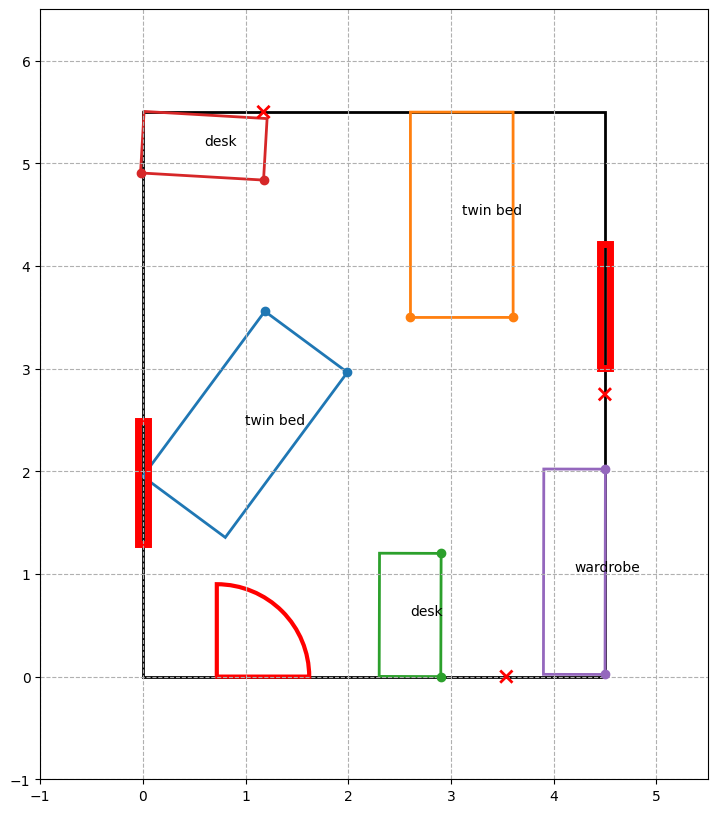

ValueError: No points given

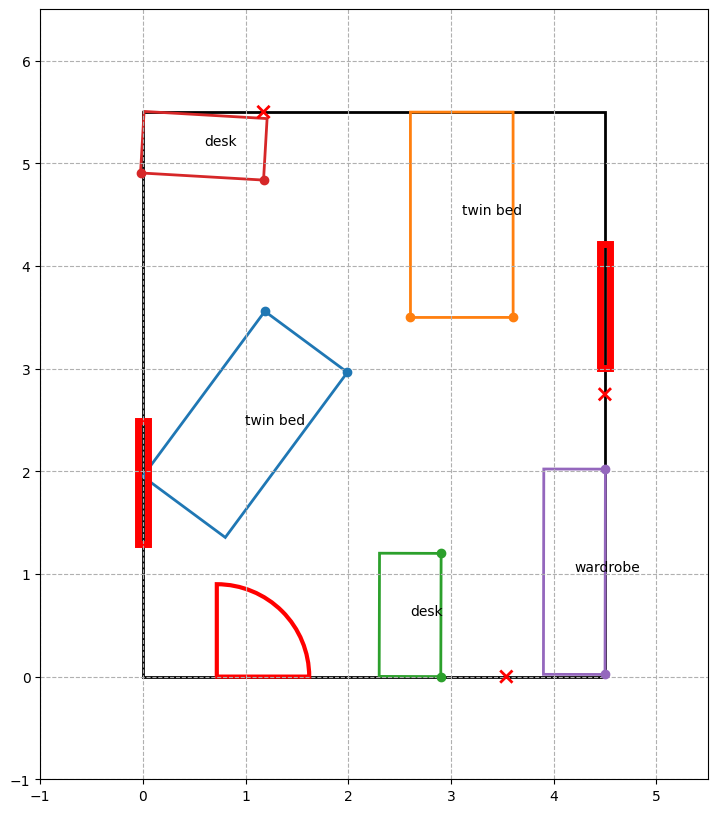

In [13]:
tol = 1e-3
tol2 = 3 
room = local_context[room_name] 
function = local_context['optimize_primary_objects']  
bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, 2*np.pi] * len(room.moving_objects))
options = {'maxiter': 500, 'ftol': 1e-6}

max_iters = 25
min_fun = np.Inf
iters = 0
chance = 0
while min_fun > tol:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(function, positions, args = (room), method = 'SLSQP', options = options) 
    if res.fun < min_fun:
        if ind_no_overlap(res.x, room) > num_primary_objects* 1e-2:
            print(f"Objects overlap. Overlap penalty: {ind_no_overlap(res.x, room)}")
        elif ind_in_bounds(res.x, room) > num_primary_objects* 1e-2:
            print(f"Objects are out of bounds. Out of bounds penalty: {ind_in_bounds(res.x, room)}")
        else: 
            min_fun = res.fun
            best_res = res
            print("New best result found. Cost: ", min_fun)
    if iters == max_iters:
        print("Max number of iterations reached.")
        if min_fun > tol2 and chance == 0:
            print("Allowing more iterations.")
            iters = 0
            chance = 1
            max_iters = 15
            tol = tol2

        else: 
            break
    iters += 1

if ind_in_bounds(best_res.x, room) > 1 or ind_no_overlap(best_res.x, room) > 1:
    print("No Solution Found.")

elif best_res is None: 
    print("No Solution Found.")

else: 
    for i in range(len(room.moving_objects)):
        room.moving_objects[i].position = best_res.x[3*i:3*i + 3]

    for i in range(len(room.regions)):
        objects = [j.index for j in room.moving_objects if j.region == room.regions[i]]
        room.regions[i].x = np.mean([best_res.x[3*j] for j in objects])
        room.regions[i].y = np.mean([best_res.x[3*j + 1] for j in objects]) 

    print(f"Final cost value: {min_fun}")
    room.draw()
    room.draw(draw_regions = True)

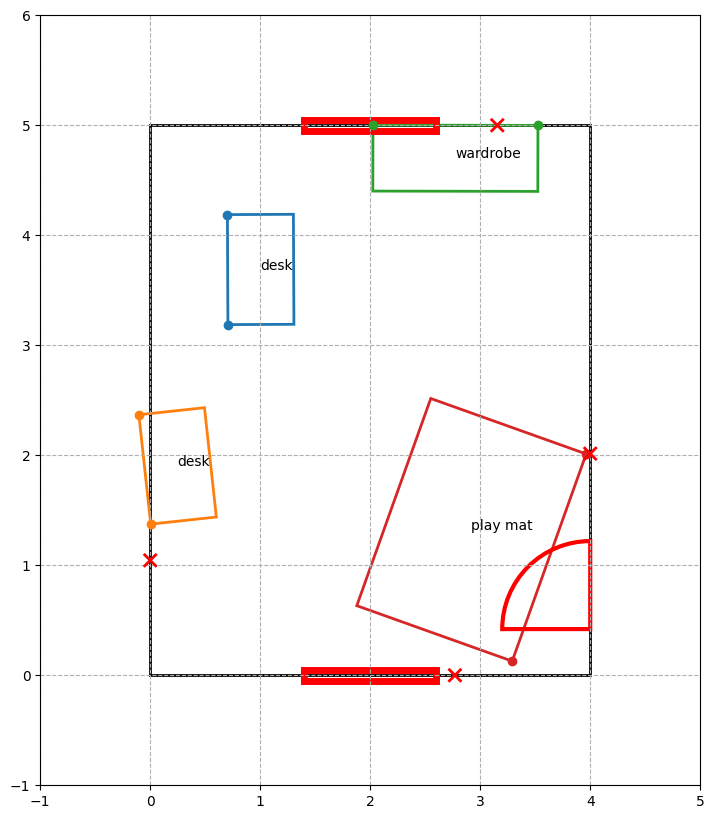

Total area of objects: 5.1, Total area of room: 20, Percentage of room taken up by objects: 25.5%


In [ ]:
best_res = res
for i in range(len(room.moving_objects)):
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3]

for i in range(len(room.regions)):
    objects = [j.index for j in room.moving_objects if j.region == room.regions[i].name]
    room.regions[i].x = np.mean([best_res.x[3*j] for j in objects])
    room.regions[i].y = np.mean([best_res.x[3*j + 1] for j in objects]) 

room.moving_objects = room.moving_objects[1:]
room.draw()
areas = 0
for obj in room.moving_objects:
    areas += obj.width * obj.length

total_area = room.width * room.length
print(f"Total area of objects: {areas}, Total area of room: {total_area}, Percentage of room taken up by objects: {areas/total_area * 100}%") 


In [ ]:
exec(response6)

In [ ]:
global_context2 = globals().copy()
local_context2 = {}
exec(response7, global_context2, local_context2)

In [ ]:
tol = 1e-3
tol2 = 15
function2 = local_context2['optimize_secondary_objects']
options = {'maxiter': 500, 'ftol': 1e-6}
room = local_context[room_name]
max_iters = 30
min_fun = np.Inf
iters = 0
chance = 0
while min_fun > tol:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.regions)):
        positions[3*i] = room.moving_objects[i].position[0]
        positions[3*i + 1] = room.moving_objects[i].position[1]
        positions[3*i + 2] = room.moving_objects[i].position[2]
    for i in range(len(room.regions), len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)

    res = minimize(function2, positions, args = (room), method = 'SLSQP', options = options)
    print(iters, res.fun, res.message)
    if res.fun < min_fun:
        if ind_no_overlap(res.x, room) > num_secondary_objects * 5e-2:
            print(f"Objects overlap: {ind_no_overlap(res.x, room)} ")
        elif ind_in_bounds(res.x, room) > num_secondary_objects * 5e-2:
            print(f"Objects are out of bounds: {ind_in_bounds(res.x, room)}")
        else:
            min_fun = res.fun
            best_res = res
    if iters == max_iters:
        print("Max number of iterations reached.")
        if min_fun > tol2 and chance == 0:
            print("Allowing more iterations")
            iters = 0
            chance = 1
            max_iters = 15
            tol = tol2
        else:
            break
    iters += 1

if ind_in_bounds(res.x, room) > 1 or ind_no_overlap(res.x, room) > 1:
    print("No Solution Found.")

else:
    for i in range(len(room.moving_objects)):
        room.moving_objects[i].position = best_res.x[3*i:3*i + 3]
        print(f"Final cost value: {min_fun}")
    room.draw()
    room.draw(draw_regions = True)

all is not a valid side of the object.
all is not a valid side of the object.


TypeError: p_next_to() got an unexpected keyword argument 'max_dist'